In [1]:
import sys
import numpy as np
import math
import pandas as pd
import random

from scipy import stats

%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rc('font',family='serif')
matplotlib.rc('font',weight='bold')
matplotlib.rc('font',size=16)
matplotlib.rcParams['axes.labelweight'] = 'bold'

from recommender_functions import *
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, roc_auc_score

In [2]:
week = 'Week3'
day  = 'Tues'

In [3]:
# Get the ratings by user ID: starts at user index 1 
r = pd.read_csv('goodbooks-10k/ratings.csv')
df_ratings = pd.DataFrame(r)

# Add counts to the df
cut_u, cut_b = 175, 1 #175, 1
df_ratings['user_counts'] = df_ratings.groupby(['user_id'])['book_id'].transform('count')
df_ratings['book_counts'] = df_ratings.groupby(['book_id'])['user_id'].transform('count')
df_ratings_cut = df_ratings.query('user_counts > %d '%(cut_u))

# Add an index for the user for matrix making later
df_ratings_cut['user_idx'] = pd.Categorical(df_ratings_cut['user_id']).codes 
df_ratings_cut['book_idx'] = pd.Categorical(df_ratings_cut['book_id']).codes 

# ...but also do a groupby, so can plot easily
df_ratings_count_u = df_ratings.groupby(['user_id']).size().reset_index(name='Counts')

r = pd.read_csv('goodbooks-10k/books_with_genres.csv')
df_books = pd.DataFrame(r)
df_ratings_cut.head()

r = pd.read_csv('goodbooks-10k/ahack_tags_3.csv')
df_tags = pd.DataFrame(r)
df_tags['tag_index'] = pd.Categorical(df_tags['tag_id']).codes 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [59]:
print( min(df_ratings_cut['book_idx'].values),max(df_ratings_cut['book_idx'].values))
print( min(df_ratings_cut['user_idx'].values),max(df_ratings_cut['user_idx'].values))
print( min(df_ratings_cut['book_id'].values),max(df_ratings_cut['book_id'].values))

0 7336
0 536
1 10000


In [57]:
#plt.hist(df_books.book_id.values,range=(0,10))

In [58]:
# Set number of books and users variables for later use
N_BOOKS = len(df_ratings_cut.book_id.unique()) 
N_USERS = len(df_ratings_cut.user_id.unique())

print(N_BOOKS,N_USERS)

7337 537


In [5]:
df_books.head()
df_tags.head()

,tag_id,tag_name,tag_index
0,1691,adventure,0
1,2580,animals,1
2,2768,apocalyptic,2
3,2938,art,3
4,4605,biography,4


## Build a Rank Matrix

In [198]:
# First, define a matrix size num_books x num_users
ratings_genre_mat = np.zeros((N_USERS,N_BOOKS))
ratings_mat = np.zeros((N_USERS,N_BOOKS))
binary_mat = np.zeros((N_USERS,N_BOOKS))

Y, R = ratings_mat, binary_mat

genre_list_dict = []

# Now fill the rank matrix and validation matrix
for i in range(df_ratings_cut.shape[0]):
    user_i = df_ratings_cut.user_idx.values[i] # This goes from 0 -> 536
    book_i = df_ratings_cut.book_idx.values[i] # This goes from 0 -> 7336
    rating_i = df_ratings_cut.rating.values[i] # This goes from 1 -> 5

    # Fill ratings + binary matrix
    ratings_mat[user_i][book_i] = rating_i
    binary_mat[user_i][book_i] = 1
    
    # Now fill the genre tag matrix
    # First link ratings matrix entry to its book in df_books
    actual_book_i = df_ratings_cut.book_id.values[i]               # book_id goes from 1 -> 10000
    book_q = df_books.loc[df_books['book_id'] == actual_book_i]
    genre, tag_id = book_q.genre.values[0], book_q.tag_id.values[0] 
    
    ratings_genre_mat[user_i][book_i] = int(tag_id)    

In [60]:
# Now store the top 3 genre preferences per user 
top_3_genres_per_user = np.zeros((N_USERS,4))
top_3_genres_names_per_user = []

for rowi in range(ratings_genre_mat.shape[0]):
    
    i = ratings_genre_mat[rowi]
    
    unique, counts = np.unique(i,return_counts=True)

    pred_idxs_sorted = np.argsort(counts)
    pred_idxs_sorted = pred_idxs_sorted[::-1]
    #print(pred_idxs_sorted[1:4])
    # Start at 1, not 0, to avoid the 0's which are most of the space
    top_3_genres_per_user[rowi][0] = unique[pred_idxs_sorted[1]] #counts[pred_idx_sorted[1]]
    top_3_genres_per_user[rowi][1] = unique[pred_idxs_sorted[2]] #counts[pred_idx_sorted[1]]
    top_3_genres_per_user[rowi][2] = unique[pred_idxs_sorted[3]] #counts[pred_idx_sorted[1]]
    top_3_genres_per_user[rowi][3] = unique[pred_idxs_sorted[4]] #counts[pred_idx_sorted[1]]
    
    first_pick = df_tags.query('tag_id == %d'%int(top_3_genres_per_user[rowi][0]))
    second_pick = df_tags.query('tag_id == %d'%int(top_3_genres_per_user[rowi][1]))
    third_pick = df_tags.query('tag_id == %d'%int(top_3_genres_per_user[rowi][2]))

    user_pref_v = [first_pick['tag_name'].values[0], second_pick['tag_name'].values[0], third_pick['tag_name'].values[0]]

    top_3_genres_names_per_user.append(user_pref_v)

In [61]:
print('User prefs: ',top_3_genres_names_per_user[0])

User prefs:  ['romance', 'fantasy', 'contemporary']


In [62]:
# Split between train and test
train_set, test_set = train_test_split(ratings_mat,split=20)

In [63]:
# Get user similarity
user_similarity = fast_similarity(train_set,kind='user')

In [204]:
#print(user_similarity[-1][:10])
#print(user_similarity.T[-1][:10])

## Get predictions taking into account all entries

In [74]:
# Get user predictions 
user_prediction = predict_fast_simple(train_set, user_similarity, kind='user')
print ('User-based CF MSE: ' + str(get_mse(user_prediction, test_set)))

(537, 7337) (537, 537)
User-based CF MSE: 12.11293520701285


## Now let's look at only top k entries

In [15]:
# k = 30 seems to be the mse minimum
user_prediction_topk = predict_topk(train_set, user_similarity, kind='user', k=30)
print( 'Top-k User-based CF MSE: ' + str(get_mse(user_prediction_topk, test_set)))

537
Top-k User-based CF MSE: 10.805375240632316


In [207]:
def predict_fast_topk(ratings, similarity, kind='user', k=40):

    pred = np.zeros(ratings.shape)

    
    top_k_users = [np.argsort(similarity[:,-1])[:-k-1:-1]]

    for j in range(ratings.shape[1]):
        pred[-1, j] = similarity[-1, :][top_k_users].dot(ratings[:, j][top_k_users])
        pred[-1, j] /= np.sum(np.abs(similarity[-1, :][top_k_users]))

    return pred

In [214]:
user_prediction_topk = predict_topk(train_set, user_similarity, kind='user', k=30)
#This one only works for the last user input; for interface
#user_prediction_topk = predict_fast_topk(train_set, user_similarity, kind='user', k=30)

537


In [210]:
# Finally, weight the initial predictions made by the system
# Need to vectorize this
weight = 1.3
threshold = 3. / weight

user_prediction_topk_genre = user_prediction_topk.copy()
user_genre_coords = np.argwhere( user_prediction_topk_genre > threshold)

for c in user_genre_coords:
    x, y = c[0], c[1]
    rating_i = user_prediction_topk_genre[x][y]

    # Get book id from the book_idx to link us to the df_books db genre for this rating entry
    ratings_book_id = df_ratings_cut.loc[df_ratings_cut['book_idx'] == int(y)]['book_id'].values[0]
    genre_xy = df_books.loc[df_books['book_id'] == ratings_book_id]['genre'].values[0]
    title_xy = df_books.loc[df_books['book_id'] == ratings_book_id]['title'].values[0]

    #print('\nRecommended Genre: {} {}'.format(genre_xy, user_prediction_topk_genre[x][y]))

    if genre_xy not in top_3_genres_names_per_user[x]:
        user_prediction_topk_genre[x][y] *= weight
    #    print('Title: {}'.format(title_xy)) 
    #    print('New weight: ',user_prediction_topk_genre[x][y])

## And now we validate

In [102]:
# Get info for the unweighted matrix
nonzero_test = test_set > 0

# get non-zero test entries, since we can't evaluate for unsubmitted ratings!
y_true = test_set[nonzero_test]
y_pred_topk = user_prediction_topk[nonzero_test] #+1
y_pred_topk_genre = user_prediction_topk_genre[nonzero_test]

print('True: ',min(y_true),max(y_true))
print('Pred top k: ',min(y_pred_topk),max(y_pred_topk))
print('Pred top k genre: ',min(y_pred_topk_genre),max(y_pred_topk_genre))

# Continous version of predictions, scaled to 0, 1
y_pred_scaled_topk  = (y_pred_topk - min(y_pred_topk)) / max(y_pred_topk)
y_pred_scaled_topk_genre  = (y_pred_topk_genre - min(y_pred_topk_genre)) / max(y_pred_topk_genre)

# binarize true values and predictions
y_true_binarized = binarize(y_true.copy(), 3)
y_pred_binarized_topk = binarize(y_pred_topk.copy(), 3) 
y_pred_binarized_topk_genre = binarize(y_pred_topk_genre.copy(), 3) 

True:  1.0 5.0
Pred top k:  0.0 4.3861088778618535
Pred top k genre:  0.0 5.263330653434224


In [103]:
print(min(y_pred_scaled_topk),max(y_pred_scaled_topk))
print(min(y_pred_scaled_topk_genre),max(y_pred_scaled_topk_genre))

0.0 1.0
0.0 1.0


In [199]:
print( 'Recall: %0.3f' % recall_score(y_true_binarized, y_pred_binarized_topk))
print( 'Precision: %0.3f' % precision_score(y_true_binarized, y_pred_binarized_topk))
print( 'F1 score: %0.3f' % f1_score(y_true_binarized, y_pred_binarized_topk))

print( '\n With genre: ')
print( 'Recall: %0.3f' % recall_score(y_true_binarized, y_pred_binarized_topk_genre))
print( 'Precision: %0.3f' % precision_score(y_true_binarized, y_pred_binarized_topk_genre))
print( 'F1 score: %0.3f' % f1_score(y_true_binarized, y_pred_binarized_topk_genre))

# but roc-auc is more accurate when using continuous predictions.
auc_score = roc_auc_score(y_true_binarized, y_pred_scaled_topk_genre)
print( 'ROC-AUC: %0.3f' % auc_score)

Recall: 0.045
Precision: 0.998
F1 score: 0.086

 With genre: 
Recall: 0.077
Precision: 0.991
F1 score: 0.144
ROC-AUC: 0.675


In [105]:
fpr, tpr, thresholds     = roc_curve(y_true_binarized, y_pred_scaled_topk)
fpr_g, tpr_g, thresholds = roc_curve(y_true_binarized, y_pred_scaled_topk_genre)

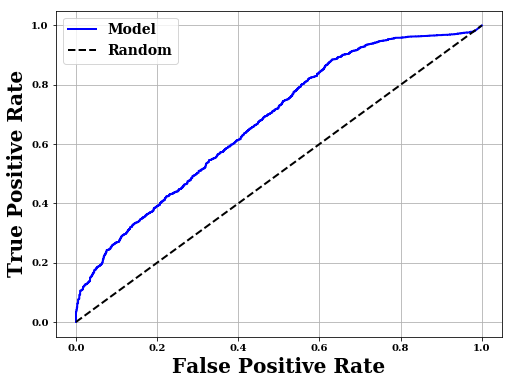

In [129]:
# recall, precision, and f1 are definied for binarized predictions  
# plot ROC curve
plt.figure(figsize=(8, 6))
#plt.plot(fpr, tpr, lw=2,color='green',label='New Model (k > 30)')
plt.plot(fpr_g, tpr_g, lw=2,color='blue',label='Model') #New Model (k > 30 + genre) ')
plt.plot([0, 1], [0, 1], 'k--',lw=2,label='Random')
#plt.title('ROC') # (AUC=%0.3f)' % auc_score)
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.grid(True)
plt.legend(fontsize=14)
plt.savefig('Plots/%s_%s_roc.png'%(week,day),bbox_to_inches='tight')

In [137]:
f = open('hold_roc_values.txt','w')
#print(len(fpr_g))

for i in range(len(fpr_g)):
    f.write(str(fpr_g[i]))
    f.write(' ')

f.write('\n\n')
for i in range(len(tpr_g)):
    f.write(str(tpr_g[i]))
    f.write(' ')

f.close()

In [111]:
def recall_at_k(true, pred, user_ids, k, tol=2.5):
    unique_users = np.unique(user_ids)
    pred_binarized = binarize(pred.copy(), tol)
    #print(pred_binarized)
    recalls = np.zeros(unique_users.size)
    for i in range(unique_users.size):
        user_ind = user_ids == unique_users[i]
        user_true = true[user_ind]
        user_pred = pred[user_ind]
        user_pred_binarized = pred_binarized[user_ind]
        #print("in here",pred_binarized[user_ind])
        ranked_ind = np.argsort(-user_pred)[:k]
        recalls[i] = recall_score(user_true[ranked_ind], user_pred_binarized[ranked_ind])
    #print(recalls)
    return np.mean(recalls[recalls > 0])

In [112]:
user_ids = np.tile(np.array([np.arange(test_set.shape[0])]).T, (1, test_set.shape[1]))[nonzero_test]
#print(user_ids)
#print(y_true_binarized)

In [113]:
print( 'recall @4 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk, user_ids, 4))
print( 'recall @8 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk, user_ids, 8))
print( 'recall @16 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk, user_ids, 16))
print( 'recall @32 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk, user_ids, 32))

print( '\n\nrecall @4 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk_genre, user_ids, 4, tol=3))
print( 'recall @8 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk_genre, user_ids, 8, tol=3))
print( 'recall @16 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk_genre, user_ids, 16, tol=3))
print( 'recall @32 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk_genre, user_ids, 32, tol=3))

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


recall @4 : 0.598
recall @8 : 0.328
recall @16 : 0.172
recall @32 : 0.141


recall @4 : 0.496
recall @8 : 0.269
recall @16 : 0.142
recall @32 : 0.116


In [211]:
weight = 1.5
threshold = 3. / weight

user_prediction_topk_genre = user_prediction_topk.copy()
user_genre_coords = np.argwhere( user_prediction_topk_genre > threshold)

for c in user_genre_coords:
    x, y = c[0], c[1]
    rating_i = user_prediction_topk_genre[x][y]

    # Get book id from the book_idx to link us to the df_books db genre for this rating entry
    ratings_book_id = df_ratings_cut.loc[df_ratings_cut['book_idx'] == int(y)]['book_id'].values[0]
    genre_xy = df_books.loc[df_books['book_id'] == ratings_book_id]['genre'].values[0]
    title_xy = df_books.loc[df_books['book_id'] == ratings_book_id]['title'].values[0]

    if genre_xy not in top_3_genres_names_per_user[x]:
        user_prediction_topk_genre[x][y] *= weight
        if x == N_USERS - 2 and user_prediction_topk_genre[x][y] > 4:
            print (y,genre_xy, title_xy, ratings_book_id, user_prediction_topk_genre[x][y])

In [213]:
# MAKE SURE INDEXING IS RIGHT HERE**g
# Sort first user's predictions from highest to lowest
user_i = -1
pred_idxs_sorted = np.argsort(user_prediction_topk_genre[user_i] )
pred_idxs_sorted = pred_idxs_sorted[::-1]
print(pred_idxs_sorted)

print( "Top recommendations for you:")
for i in range(8):
    
    ratings_book_idx = int(pred_idxs_sorted[i])
    df_temp = df_ratings_cut.query('book_idx == %d' % ratings_book_idx)
    book_id = df_temp.book_id.values[0]    
    
    new_book = df_books.query('book_id == %d'%book_id)    
    genre_i = new_book['genre'].values[0]

    print('Predicting rating %0.2f for book "%s", genre: "%s"' % \
    (user_prediction_0[pred_idxs_sorted[i]],new_book['title'].values[0],new_book['genre'].values[0]))
      
j = 0
print ("\nOriginal ratings provided:")
print( top_3_genres_names_per_user[-2])
# for i in range(len(ratings_mat[user_i])):  
#     #print(i,user_i, sum(ratings_mat[user_i]))
#     if ratings_mat[user_i][i] > 0:
#         j += 1
#         df_temp = df_ratings_cut.query('book_idx == %d' % i)
#         book_id = df_temp.book_id.values[0]    
#         new_book_2 = df_books.query('book_id == %d' % book_id)
#         print ('Rated %d for "%s", genre: "%s"' % (ratings_mat[user_i][i],new_book_2['title'].values[0],new_book_2['genre'].values[0]))
    
#     if j > 5:
#         break

[ 250  537  408 ... 4593 4594 7336]
Top recommendations for you:
Predicting rating 1.35 for book "The Cat in the Hat", genre: "kids"
Predicting rating 0.38 for book "Midnight in the Garden of Good and Evil", genre: "mystery"
Predicting rating 0.48 for book "Fried Green Tomatoes at the Whistle Stop Cafe", genre: "lgbt"
Predicting rating 0.96 for book "The Cider House Rules", genre: "default"
Predicting rating 1.07 for book "The Clan of the Cave Bear (Earth's Children, #1)", genre: "romance"
Predicting rating 1.64 for book "Oh, The Places You'll Go!", genre: "kids"
Predicting rating 0.65 for book "The Shipping News", genre: "contemporary"
Predicting rating 0.94 for book "Death of a Salesman", genre: "plays"

Original ratings provided:
['fantasy', 'classic', 'romance']


In [162]:
print(2.72 / 1.23)
print(2.2*1.45)


2.2113821138211383
3.19


In [ ]:
import requests
CLIENT_ID = 'qc6JdYnnj3G1fpQSsp4n1w'
CLIENT_SECRET = 'zD8IroPsQVDvco4V2u9h6hMgV1F3lsIO6FxKiq9eU'

In [ ]:
multi_r = requests.get('https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET')
